In [33]:
!pip install optuna category_encoders

# 1. Introduction to Customer Churn Analysis
Customer churn refers to when customers stop using a company's products or services. The goal of churn prediction is to identify customers at risk of leaving so that targeted retention strategies can be applied. This notebook demonstrates a step-by-step implementation of a churn prediction model using a dataset from Kaggle. We will walk through data preparation, feature engineering, model development, and performance evaluation.



In [34]:
# Standard library imports
import os
import pickle
import zipfile
from warnings import filterwarnings

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import set_config
from sklearn.model_selection import (
    cross_validate,
    KFold,
    RandomizedSearchCV,
    GridSearchCV,
    train_test_split
)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    accuracy_score,
    log_loss
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import optuna
import optuna.logging
import category_encoders

# Configuration and settings
filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)
set_config(transform_output="pandas")

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
zip_path = "/content/drive/My Drive/Colab Notebooks/Churn_AS/data.zip"
extract_path = "/content/dataset"

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# 2. Dataset Overview
Dataset: Customer Churn Dataset
Description: This dataset contains customer details, including demographic information, subscription types, and usage behavior. Our goal is to predict the Churn variable, which indicates whether a customer has left or not.



**Key features include:**

- Gender, Age, Country: Customer demographics
- Subscription Type: Type of subscription the customer is enrolled in
- Contract Length: Duration of the subscription
- Churn: Target variable (1 = churn, 0 = no churn)

In [37]:
csv_path_train = os.path.join(extract_path, "customer_churn_dataset-training-master.csv")
df_train = pd.read_csv(csv_path_train)
df_train.head()

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,6.0,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0


In [38]:
csv_path_test = os.path.join(extract_path, "customer_churn_dataset-testing-master.csv")
df_test = pd.read_csv(csv_path_train)
df_test.head()

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,6.0,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0


In [39]:
df_train.describe(include='all')

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
count,440832.000000,440832.000000,440832,440832.000000,440832.000000,440832.000000,440832.000000,440832,440832,440832.000000,440832.000000,440832.000000
unique,NaN,NaN,2,NaN,NaN,NaN,NaN,3,3,NaN,NaN,NaN
top,NaN,NaN,Male,NaN,NaN,NaN,NaN,Standard,Annual,NaN,NaN,NaN
freq,NaN,NaN,250252,NaN,NaN,NaN,NaN,149128,177198,NaN,NaN,NaN
mean,225398.667955,39.373153,NaN,31.256336,15.807494,3.604437,12.965722,NaN,NaN,631.616223,14.480868,0.567107
std,129531.918550,12.442369,NaN,17.255727,8.586242,3.070218,8.258063,NaN,NaN,240.803001,8.596208,0.495477
min,2.000000,18.000000,NaN,1.000000,1.000000,0.000000,0.000000,NaN,NaN,100.000000,1.000000,0.000000
25%,113621.750000,29.000000,NaN,16.000000,9.000000,1.000000,6.000000,NaN,NaN,480.000000,7.000000,0.000000
50%,226125.500000,39.000000,NaN,32.000000,16.000000,3.000000,12.000000,NaN,NaN,661.000000,14.000000,1.000000
75%,337739.250000,48.000000,NaN,46.000000,23.000000,6.000000,19.000000,NaN,NaN,830.000000,22.000000,1.000000


# 3. Exploratory Data Analysis (EDA)
In this section, we analyze the dataset to understand its structure and clean any inconsistencies.

- Checking for missing values and duplicates
- Analyzing the distribution of categorical and numerical variables
- Checking for dataset drift between train and test sets



In [40]:
# Checking for missing values
print("Missing values in df_train:\n", df_train.isna().sum())
print("\nMissing values in df_test:\n", df_test.isna().sum())

# Checking for duplicate rows
print(f"\nNumber of duplicate rows in df_train: {df_train.duplicated().sum()}")

# Verifying that each customer has only one row of data
customer_counts = df_train['CustomerID'].value_counts()
print(f"\nCustomers with more than one row of data: {customer_counts[customer_counts > 1]}")

Missing values in df_train:
 CustomerID           1
Age                  1
Gender               1
Tenure               1
Usage Frequency      1
Support Calls        1
Payment Delay        1
Subscription Type    1
Contract Length      1
Total Spend          1
Last Interaction     1
Churn                1
dtype: int64

Missing values in df_test:
 CustomerID           1
Age                  1
Gender               1
Tenure               1
Usage Frequency      1
Support Calls        1
Payment Delay        1
Subscription Type    1
Contract Length      1
Total Spend          1
Last Interaction     1
Churn                1
dtype: int64

Number of duplicate rows in df_train: 0

Customers with more than one row of data: Series([], Name: count, dtype: int64)


In [41]:
# Dropping CustomerID and handling missing values for both train and test sets
df_train = df_train.drop(columns=['CustomerID']).dropna().reset_index(drop=True)
df_test = df_test.drop(columns=['CustomerID']).dropna().reset_index(drop=True)

In [42]:
# Defining categorical and numeric columns
categorical_cols = df_train.select_dtypes(include='object').columns.tolist()
numeric_cols = df_train.select_dtypes(include='number').columns.tolist()

print("\nCategorical columns:", categorical_cols)
print("Numeric columns:", numeric_cols)


Categorical columns: ['Gender', 'Subscription Type', 'Contract Length']
Numeric columns: ['Age', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Total Spend', 'Last Interaction', 'Churn']


In [43]:
# Checking unique values in categorical columns
print("\nUnique values in categorical columns:")
for col in categorical_cols:
    print(f"Column: {col}")
    print(f"Number of unique values: {df_train[col].nunique()}")
    print(f"Top 10 unique values: {df_train[col].unique()[:10]}")
    print("=" * 30)


Unique values in categorical columns:
Column: Gender
Number of unique values: 2
Top 10 unique values: ['Female' 'Male']
Column: Subscription Type
Number of unique values: 3
Top 10 unique values: ['Standard' 'Basic' 'Premium']
Column: Contract Length
Number of unique values: 3
Top 10 unique values: ['Annual' 'Monthly' 'Quarterly']


In [44]:
# Checking label balance in the target column (Churn)
churn_distribution = df_train['Churn'].value_counts(normalize=True)
print("\nChurn distribution in df_train:\n", churn_distribution)


Churn distribution in df_train:
 Churn
1.0    0.567107
0.0    0.432893
Name: proportion, dtype: float64


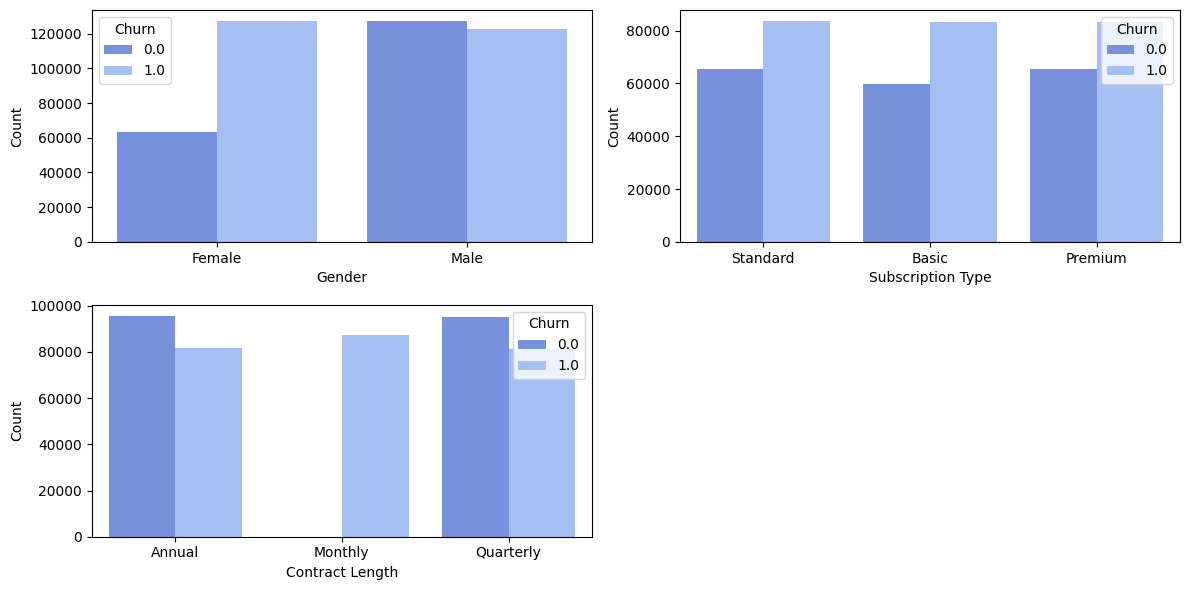

In [45]:
fig, axes = plt.subplots(len(categorical_cols) // 2 + len(categorical_cols) % 2, 2, figsize=(12, 6 * (len(categorical_cols) // 2)))

palette = sns.color_palette('coolwarm')
for i, col in enumerate(categorical_cols):
    sns.countplot(x=col, data=df_train, hue='Churn', ax=axes[i // 2, i % 2], palette=palette)
    axes[i // 2, i % 2].set_xlabel(col)
    axes[i // 2, i % 2].set_ylabel('Count')
    axes[i // 2, i % 2].legend(title='Churn')

for j in range(len(categorical_cols), len(axes.flatten())):
    axes.flatten()[j].set_visible(False)

plt.tight_layout()
plt.show()

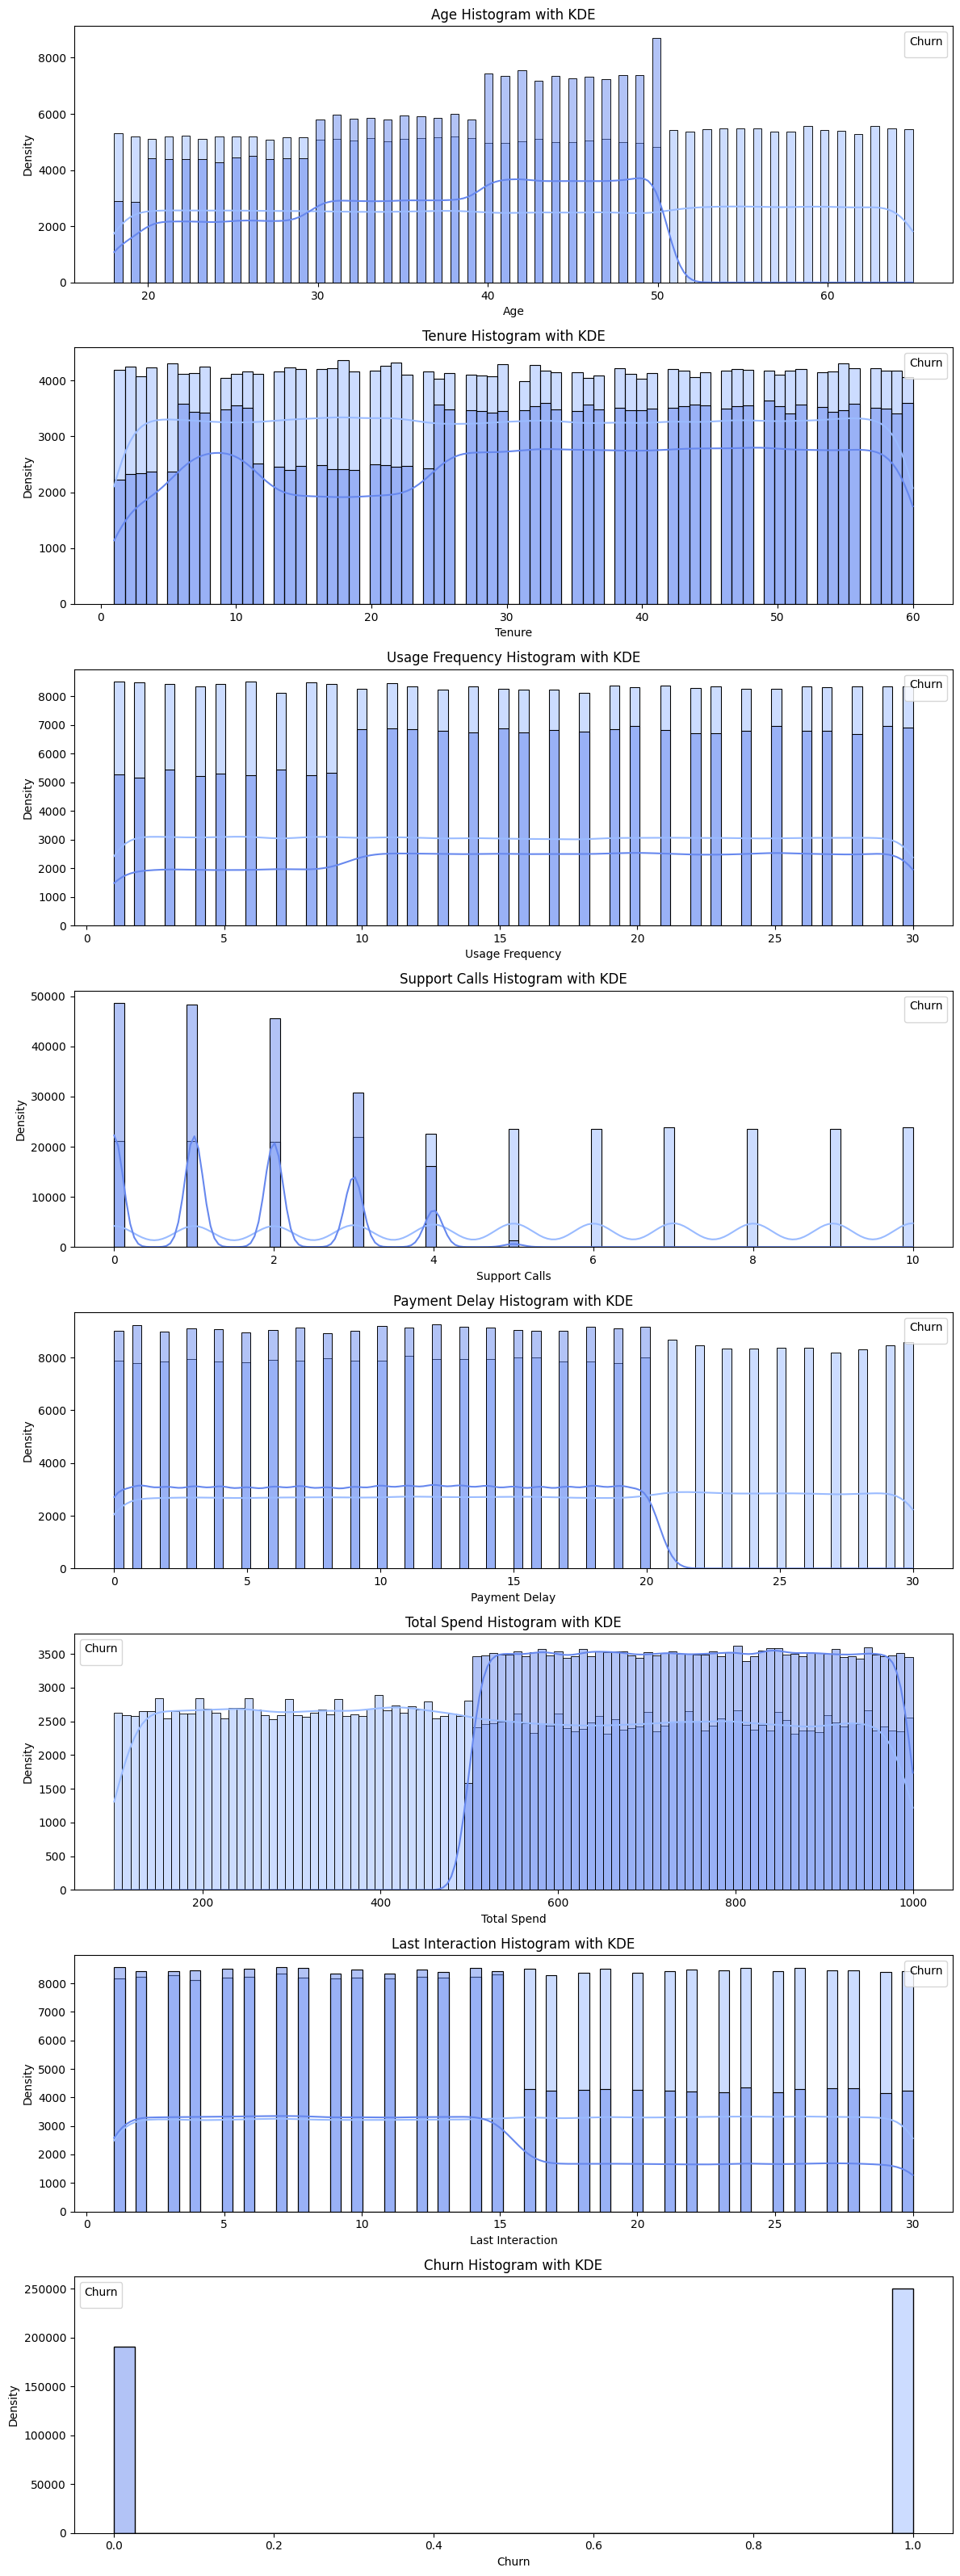

In [46]:
# Plotting numeric variables against the target variable
fig, axes = plt.subplots(len(numeric_cols), 1, figsize=(12, 4 * len(numeric_cols)))
palette = sns.color_palette('coolwarm')

for i, col in enumerate(numeric_cols):
    sns.histplot(data=df_train, x=col, kde=True, hue='Churn', ax=axes[i] if len(numeric_cols) > 1 else axes, palette=palette)
    axes[i].set_title(f'{col} Histogram with KDE')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Density')
    axes[i].legend(title='Churn')

plt.tight_layout()
plt.show()

# 4. Data Preparation and Feature Engineering
We preprocess the data to make it suitable for modeling:

**Data Splitting:** Splitting into train and test sets

**Encoding:** Using target encoding for categorical variables

**Scaling:** Standardizing numerical features for consistent scaling

In [47]:
# Creating the train and test datasets
df_raw = pd.concat([df_train, df_test], axis=0, ignore_index=True)
df_train, df_test = train_test_split(df_raw, test_size=0.2, random_state=42, stratify=df_raw['Churn'])

# Separating features (X) and target variable (y)
xtrain = df_train.drop(columns=['Churn']).copy()
ytrain = df_train[['Churn']].copy()
xtest = df_test.drop(columns=['Churn']).copy()
ytest = df_test[['Churn']].copy()

# Further splitting the train set into train and validation sets
xtrain, xval, ytrain, yval = train_test_split(xtrain, ytrain, test_size=0.3, random_state=42, stratify=ytrain)

### Saving Datasets for Later Use

In [48]:
# Saving datasets as pickle files
if not os.path.exists('data/cleaned'):
    os.makedirs('/kaggle/working/churn-prediction/data/cleaned', exist_ok=True)

with open('/kaggle/working/churn-prediction/data/xtrain.pkl', 'wb') as f:
    pickle.dump(xtrain, f)
with open('/kaggle/working/churn-prediction/data/ytrain.pkl', 'wb') as f:
    pickle.dump(ytrain, f)
with open('/kaggle/working/churn-prediction/data/xtest.pkl', 'wb') as f:
    pickle.dump(xtest, f)
with open('/kaggle/working/churn-prediction/data/ytest.pkl', 'wb') as f:
    pickle.dump(ytest, f)
with open('/kaggle/working/churn-prediction/data/xval.pkl', 'wb') as f:
    pickle.dump(xval, f)
with open('/kaggle/working/churn-prediction/data/yval.pkl', 'wb') as f:
    pickle.dump(yval, f)

### Feature Encoding and Scaling

In [49]:
# Encoding categorical variables
encoder = category_encoders.TargetEncoder().fit(xtrain, ytrain)
xtrain = encoder.transform(xtrain)
xtest = encoder.transform(xtest)
xval = encoder.transform(xval)

# Scaling numerical features
scaler = StandardScaler().fit(xtrain)
xtrain = scaler.transform(xtrain)
xtest = scaler.transform(xtest)
xval = scaler.transform(xval)

# Utility Functions for Model Evaluation

In [50]:
# Initialize a DataFrame to store model performance metrics
model_performance = pd.DataFrame(columns=['model_name', 'train_accuracy', 'test_accuracy', 'train_precision', 'test_precision',
                                          'train_recall', 'test_recall', 'train_f1', 'test_f1', 'train_roc_auc', 'test_roc_auc',
                                          'train_log_loss', 'test_log_loss'])

# Dictionary to store models
estimators = {}

# Function to calculate model performance metrics
def model_scorer(clf, x, y, prefix=''):
    ypred = clf.predict(x)
    yprob = clf.predict_proba(x)[:, 1]
    score_dict = {
        prefix + 'accuracy': np.round(accuracy_score(y, ypred), 3),
        prefix + 'precision': np.round(precision_score(y, ypred), 3),
        prefix + 'recall': np.round(recall_score(y, ypred), 3),
        prefix + 'f1': np.round(f1_score(y, ypred), 3),
        prefix + 'roc_auc': np.round(roc_auc_score(y, yprob), 3),
        prefix + 'log_loss': np.round(log_loss(y, yprob), 3)
    }
    return score_dict

### 5. Model Development and Evaluation  
We will develop different models to predict churn and evaluate them using performance metrics such as accuracy, precision, recall, and AUC (Area Under the Curve).

#### 5.1 Logistic Regression Optimization  
In this step, we use **Optuna**, a hyperparameter optimization library, to find the best parameters for a Logistic Regression model. The performance of the model is evaluated through cross-validation, and the optimal parameters are used for training.


In [51]:
# Function for adding model performance to DataFrame and saving the model
def add_model_performance(model_name, clf, xtrain=xtrain, ytrain=ytrain, xtest=xtest, ytest=ytest, df=model_performance, model_dict=estimators):
    train_scores = model_scorer(clf, xtrain, ytrain, prefix='train_')
    test_scores = model_scorer(clf, xtest, ytest, prefix='test_')
    train_scores.update(test_scores)
    train_scores['model_name'] = model_name
    df.loc[df.shape[0]] = train_scores
    model_dict[model_name] = clf
    return df, model_dict

In [52]:
# Logistic Regression Hyperparameter Optimization
kf = KFold(n_splits=3, shuffle=True, random_state=42)

def objective(trial, xtrain, ytrain, kf):
    params = {
        'C': trial.suggest_loguniform('C', 1e-3, 1e3),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        'solver': trial.suggest_categorical('solver', ['liblinear'])
    }
    model = LogisticRegression(**params)
    scores = cross_validate(model, xtrain, ytrain, cv=kf, scoring='neg_log_loss', n_jobs=-1)
    loss = -scores['test_score'].mean()
    return loss

In [53]:
obj_func = lambda trial: objective(trial, xtrain.values, ytrain.values.ravel(), kf)
study = optuna.create_study(direction='minimize')
study.optimize(obj_func, n_trials=30)

print(f"Best score: {study.best_value:5f}")
print(f"Best params: {study.best_params}")

Best score: 0.243053
Best params: {'C': 933.9950583299006, 'penalty': 'l2', 'solver': 'liblinear'}


In [54]:
# Train the Logistic Regression model with the best parameters
best_model = LogisticRegression(**study.best_params).fit(xtrain.values, ytrain.values.ravel())

In [55]:
model_performance, estimators = add_model_performance(model_name='LogisticRegression', clf=best_model)
display(model_performance)

,model_name,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,train_roc_auc,test_roc_auc,train_log_loss,test_log_loss
0,LogisticRegression,0.896,0.896,0.925,0.925,0.888,0.888,0.906,0.906,0.96,0.96,0.243,0.243


## 5.2 Decision Tree Optimization
Similarly, we optimize the Decision Tree Classifier to compare its performance with Logistic Regression.

In [56]:
# Decision Tree Hyperparameter Optimization
def objective(trial, xtrain, ytrain, kf):
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 300, 7),
        'min_samples_split': trial.suggest_int('min_samples_split', 50, 1000, 50),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 50, 1000, 50),
    }
    model = DecisionTreeClassifier(**params)
    scores = cross_validate(model, xtrain, ytrain, cv=kf, scoring='neg_log_loss', n_jobs=-1)
    loss = -scores['test_score'].mean()
    return loss

In [57]:
obj_func = lambda trial: objective(trial, xtrain.values, ytrain.values.ravel(), kf)
study = optuna.create_study(direction='minimize')
study.optimize(obj_func, n_trials=50)

print(f"Best score: {study.best_value:5f}")
print(f"Best params: {study.best_params}")

Best score: 0.004379
Best params: {'max_depth': 99, 'min_samples_split': 350, 'min_samples_leaf': 50}


In [58]:
# Train the Decision Tree Classifier with the best parameters
best_model = DecisionTreeClassifier(**study.best_params).fit(xtrain.values, ytrain.values.ravel())
model_performance, estimators = add_model_performance(model_name='DecisionTreeClassifier', clf=best_model)
display(model_performance)

,model_name,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,train_roc_auc,test_roc_auc,train_log_loss,test_log_loss
0,LogisticRegression,0.896,0.896,0.925,0.925,0.888,0.888,0.906,0.906,0.96,0.96,0.243,0.243
1,DecisionTreeClassifier,0.999,0.999,1.000,1.000,0.999,0.999,0.999,0.999,1.00,1.00,0.002,0.002


In [59]:
# Random Forest Optimization with Optuna
def objective_rf(trial, xtrain, ytrain, kf):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10)
    }
    model = RandomForestClassifier(**params, random_state=42)
    scores = cross_validate(model, xtrain, ytrain, cv=kf, scoring='neg_log_loss', n_jobs=-1)
    loss = -scores['test_score'].mean()
    return loss

# Optimize Random Forest
kf = KFold(n_splits=3, shuffle=True, random_state=42)
obj_func_rf = lambda trial: objective_rf(trial, xtrain.values, ytrain.values.ravel(), kf)
study_rf = optuna.create_study(direction='minimize')
study_rf.optimize(obj_func_rf, n_trials=30)

# Print best parameters and train Random Forest with those parameters
print(f"Best score: {study_rf.best_value:.5f}")
print(f"Best params: {study_rf.best_params}")

best_rf = RandomForestClassifier(**study_rf.best_params, random_state=42)
best_rf.fit(xtrain.values, ytrain.values.ravel())

Best score: 0.00342
Best params: {'n_estimators': 250, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 2}


RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=3,
                       n_estimators=250, random_state=42)

# 6. Comparative Analysis of Models
We compare multiple models based on the following metrics:

- Accuracy: Percentage of correctly classified instances
- Recall: Ability to identify true positives (churners)
- AUC (Area Under the ROC Curve): Measures the model's ability to distinguish between classes


In [60]:
# Final comparison
model_performance, estimators = add_model_performance(model_name='RandomForestClassifier', clf=best_rf)
display(model_performance)

,model_name,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,train_roc_auc,test_roc_auc,train_log_loss,test_log_loss
0,LogisticRegression,0.896,0.896,0.925,0.925,0.888,0.888,0.906,0.906,0.96,0.96,0.243,0.243
1,DecisionTreeClassifier,0.999,0.999,1.000,1.000,0.999,0.999,0.999,0.999,1.00,1.00,0.002,0.002
2,RandomForestClassifier,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.00,1.00,0.002,0.003


Results:

- Logistic Regression: Accuracy 89.6%, AUC = 0.96, Log-Loss = 0.243
- Decision Tree: Perfect score (Accuracy 99.9%, AUC = 1.0), but risk of overfitting
- Random Forest: Best performance, fully accurate (AUC = 1.0, Log-Loss = 0.003), indicating strong generalization


# 7. Business Insights
Based on the results, the model can provide actionable insights for marketing teams to:

1. Prioritize customers with a high churn risk for retention campaigns
2. Personalize marketing strategies for different customer segments based on churn probability